In [31]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour

from PIL import Image, ImageEnhance
import math

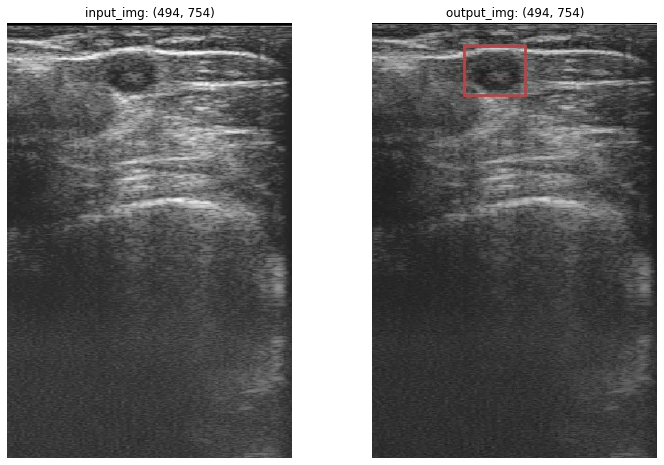

In [4]:
input_img = Image.open('YOLOv3/data/custom/images/invivo_91/0.jpg').convert('L')
output_img = Image.open('YOLOv3/output/invivo_91/0.jpg')

imgs = [input_img, output_img]
titles = [f'input_img: {input_img.size}', f'output_img: {output_img.size}']
plt.figure(figsize=(12,8))
for i, (img, title) in enumerate(zip(imgs, titles)):
    plt.subplot(1, 2, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')

In [2]:
def combineTwoLists(list_a, list_b):
    list = []
    for a, b in zip(list_a, list_b):
        list.append([a, b])
    return list

# list_a = [1, 2, 3]
# list_b = [4, 5, 6]
# list = combineTwoLists(list_a, list_b)
# np.array(list)

In [4]:
import torch
from YOLOv3.yolo_model import Darknet
from YOLOv3.detect import detect_img

device = torch.device('cuda')
model_yolo = Darknet('YOLOv3/config/yolov3-custom.cfg', img_size=416).to(device=device)
model_yolo.load_state_dict(torch.load('YOLOv3/checkpoints/invivo_91/yolov3_ckpt_34.pth'))
model_yolo.eval()

img_path = 'YOLOv3/data/custom/images/invivo_91/0.jpg'
img = Image.open(img_path)
width, height = img.size
classes = ['vein']

In [19]:
# detection
_, detections_rescaled, _ = detect_img(img_path, model_yolo, device, 416, classes, conf_thres=0.85, nms_thres=0.35, output_dir='', save_plot=False)

x1, y1, x2, y2, _, _, _ = detections_rescaled[0]

# --- Active Contour
x1 = max(0, (int)(x1.item()))
y1 = max(0, (int)(y1.item()))
x2 = min((int)(x2.item()), width)
y2 = min((int)(y2.item()), height)

# # circular init
# center = [(x1 + x2) / 2, (y1 + y2) / 2]
# radius = math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2) / 2
# print(center)
# print(radius)
# s = np.linspace(0, 2 * np.pi, 400)
# init = np.array([center[0] + radius * np.cos(s), center[1] - radius * np.sin(s)]).T

# rectangle init
horizontal = np.linspace(x1, x2, 100)
vertical = np.linspace(y1, y2, 100)

top = combineTwoLists(horizontal, [y1] * 100)
right = combineTwoLists([x2] * 100, vertical)
bottom = combineTwoLists(horizontal[::-1], [y2] * 100)
left = combineTwoLists([x1] * 100, vertical[::-1])
init = np.array(top + right + bottom + left)


Performing object detection on ---> YOLOv3/data/custom/images/invivo_91/0.jpg 	
inference_time: 0.03426527976989746s
Saving image with bbox in original image size - (754, 494):
	+ Label: vein, x1: 157.758, y1: 39.270, x2: 263.975, y2: 124.294, obj_conf: 0.85832, cls_conf: 0.99909


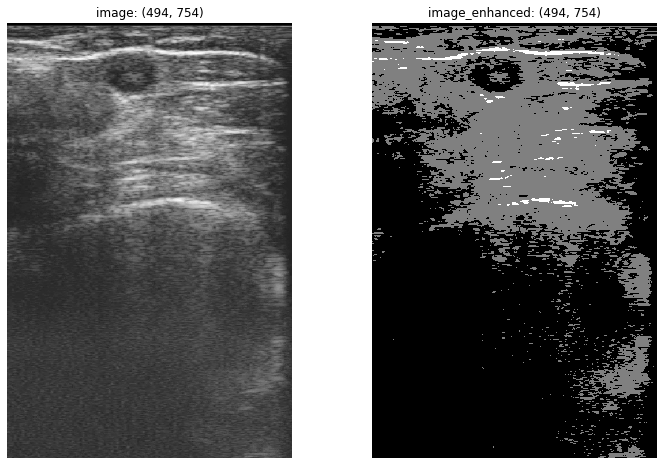

In [43]:
# import cv2
# image = cv2.imread('YOLOv3/data/custom/images/invivo_91/0.jpg', cv2.IMREAD_GRAYSCALE)
# image_enhanced = cv2.equalizeHist(image)

# image = Image.open('YOLOv3/data/custom/images/invivo_91/0.jpg').convert('L')
# image_enhanced = ImageEnhance.Contrast(image).enhance(0.025)

image = cv2.imread('YOLOv3/data/custom/images/invivo_91/0.jpg', cv2.IMREAD_GRAYSCALE)
# image = image[y1:y2, x1:x2]
image = Image.fromarray(image)
image_enhanced = ImageEnhance.Contrast(image).enhance(0.01)

imgs = [image, image_enhanced]
titles = [f'image: {image.size}', f'image_enhanced: {image_enhanced.size}']
plt.figure(figsize=(12,8))
for i, (img, title) in enumerate(zip(imgs, titles)):
    plt.subplot(1, 2, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')

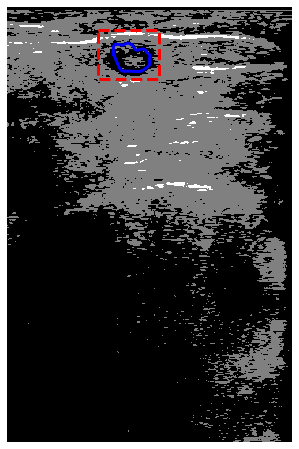

In [56]:
# img_np = np.array(img)
img_np = np.array(image_enhanced)
img_np_copy = np.copy(img_np)
for r in range(img_np.shape[0]):
    for c in range(img_np.shape[1]):
        # x = c, y = r
        if c < x1 or c > x2 or r < y1 or r > y2:
            img_np[r][c] = 255

snake = active_contour(gaussian(img_np, 2), init, alpha=0.015, w_line=-20, beta=0.0001, gamma=0.001)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img_np_copy, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.show()